# Data Augmentation

As we observed from the fine-tuning process, our fine-tuned model ended up performing 12% worse in terms of the MER metric. One main reason for this is the small dataset, which resulted in the model overfitting based on the high validation loss.

In this notebook, we will explore the process of data augmentation, which aims to increase the amount of available data for training in order to improve the model's training and to ensure that the fine-tuned model generalizes better on new data.

We will be utilising `torchaudio` for data augmentation.

In [2]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)
print(torchaudio.list_audio_backends())

2.4.1+cu121
2.4.1+cu121
['ffmpeg', 'soundfile']


In [3]:
from IPython.display import Audio

## Load the CSV and the Audio files

In [4]:
import os
from tqdm import tqdm
from google.cloud import storage
import pandas as pd

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'aphasia-chatter-5a70166fc2f1.json'

# Initialize the client
client = storage.Client()

# Define the bucket and blob (file) you want to download
bucket = client.get_bucket('speech-sit-bucket')  # Replace with your bucket name

# Specify the directory/prefix you want to retrieve files from
directory_prefix = 'fine_tune_transcripts'  # Replace with the directory in your bucket (e.g., 'audio/')

# List all blobs (files) within the specified directory
transcripts = bucket.list_blobs(prefix=directory_prefix)

audio_file_names = []

# Download directory
download_directory = 'samples/transcripts'

# Ensure the directory exists, create if necessary
if not os.path.exists(download_directory):
    os.makedirs(download_directory)

# Use tqdm to add a progress bar
for index, transcript in tqdm(enumerate(transcripts), desc="Downloading Files", unit=" files"):
    if index != 0:
        local_file_path = os.path.join(download_directory, os.path.basename(transcript.name))
        print(local_file_path)
        transcript.download_to_filename(local_file_path)

samples/transcripts/test_set.csv


samples/transcripts/train_set.csv


samples/transcripts/val_set.csv


In [5]:
import pandas as pd

In [47]:
csv_path = 'samples/transcripts/train_set.csv'
df = pd.read_csv(csv_path)
df.head()

Picture No.       Original  \
0        A-34  Boring pounds   
1        A-06           Call   
2      B-P-01   It's a woman   
3        A-26        Infront   
4        A-45        Library   

                                              Edited  patient  \
0                                    boarding pounds  al_e092   
1                                           card bed  al_e133   
2  It's a woman on the phone eh it‚Äôs a man eh o...  al_e101   
3                                             #NAME?  al_e101   
4                                            Library  al_e100   

                         audio_path  \
0    samples/audio/al_e092_A-34.m4a   
1    samples/audio/al_e133_A-06.m4a   
2  samples/audio/al_e101_B-P-01.m4a   
3    samples/audio/al_e101_A-26.m4a   
4    samples/audio/al_e100_A-45.m4a   

                                  cleaned_transcript  \
0                                      boring pounds   
1                                           card bed   
2  it s a woman on the phone eh it s a man eh oh ...   
3                                           elephant   
4                                            library   

                                               audio  sampling_rate  \
0  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...          16000   
1  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...          16000   
2  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...          16000   
3  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...          16000   
4  [ 0.000000e+00  0.000000e+00  0.000000e+00 ......          16000   

                                            features  \
0  [[-1.2991939 -1.2991939 -1.2991939 ... -1.2991...   
1  [[-1.0863969 -1.0863969 -1.0863969 ... -1.0863...   
2  [[-0.9689208  -0.9689208  -0.9689208  ... -0.2...   
3  [[-1.2470286 -1.2470286 -1.2470286 ... -1.2470...   
4  [[-0.99934685 -0.99934685 -0.99934685 ... -0.9...   

                                              labels     audio_base_name  \
0  [50257, 50258, 50358, 50362, 2865, 278, 8059, ...    al_e092_A-34.m4a   
1    [50257, 50258, 50358, 50362, 9517, 3996, 50256]    al_e133_A-06.m4a   
2  [50257, 50258, 50358, 50362, 270, 264, 257, 24...  al_e101_B-P-01.m4a   
3  [50257, 50258, 50358, 50362, 11129, 33959, 50256]    al_e101_A-26.m4a   
4         [50257, 50258, 50358, 50362, 32016, 50256]    al_e100_A-45.m4a   

                                       transcription  
0                                           cancers   
1                                 no see you i m ok   
2  it s a woman on the phone it s a man it s a ma...  
3                                      and fun yeah   
4                                           library

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211 entries, 0 to 1210
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Picture No.         1211 non-null   object
 1   Original            1211 non-null   object
 2   Edited              1211 non-null   object
 3   patient             1211 non-null   object
 4   audio_path          1211 non-null   object
 5   cleaned_transcript  1211 non-null   object
 6   audio               1211 non-null   object
 7   sampling_rate       1211 non-null   int64 
 8   features            1211 non-null   object
 9   labels              1211 non-null   object
 10  audio_base_name     1211 non-null   object
 11  transcription       1211 non-null   object
dtypes: int64(1), object(11)
memory usage: 113.7+ KB


In [7]:
import os
from tqdm import tqdm
from google.cloud import storage

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'aphasia-chatter-5a70166fc2f1.json'

# Initialize the client
client = storage.Client()

# Define the bucket and blob (file) you want to download
bucket = client.get_bucket('speech-sit-bucket')  # Replace with your bucket name

# Specify the directory/prefix you want to retrieve files from
directory_prefix = 'audio/'  # Replace with the directory in your bucket (e.g., 'audio/')

# List all blobs (files) within the specified directory
audios = bucket.list_blobs(prefix=directory_prefix)

# Download directory
download_directory = 'samples/audio'

# Ensure the directory exists, create if necessary
if not os.path.exists(download_directory):
    os.makedirs(download_directory)

df['audio_base_name'] = df['audio_path'].apply(lambda x: os.path.basename(x))

# Initialize tqdm, but set the total to len(audio_file_set), the actual number of files to download
progress_bar = tqdm(total=len(df['audio_base_name'].tolist()), desc="Downloading Files", unit=" files")

# Use the actual count of files to be downloaded to control tqdm updates
for index, audio in enumerate(audios):
    audio_file_name = os.path.basename(audio.name)
    if audio_file_name in df['audio_base_name'].tolist():
        local_file_path = os.path.join(download_directory, audio_file_name)
        audio.download_to_filename(local_file_path)
        progress_bar.update(1)  # Only update when a file is downloaded

progress_bar.close()

Apply some effects to the first audio sample:

1. Low-pass filter to remove some noinse from 300Hz and above
2. Reduce the speed by 20% (80% of the original)
3. Add some echo

In [48]:
from torchaudio.transforms import Resample

# Load the first audio file
new_sample_rate = 16000
waveform1, sample_rate = torchaudio.load(uri=df['audio_path'].iloc[0], channels_first=False)
downsampler = Resample(sample_rate, new_sample_rate)
waveform1 = downsampler(waveform1.T)
waveform1 = waveform1.T

waveform1.shape

torch.Size([95109, 2])

In [49]:
# Define effects
effect = ",".join(
    [
        "aecho=0.8:0.88:30:0.4" # Simulating a clinical reverb environment
    ],
)

def apply_effect(waveform, sample_rate, effect):
    effector = torchaudio.io.AudioEffector(effect=effect)
    return effector.apply(waveform, sample_rate)

waveform1_echo = apply_effect(waveform1, new_sample_rate, effect)

print(waveform1.shape, new_sample_rate)
print(waveform1_echo.shape, new_sample_rate)

torch.Size([95109, 2]) 16000
torch.Size([95589, 2]) 16000


We can see that the modified file is longer as the shape is higher. Let's listen to the audio.

In [50]:
import matplotlib.pyplot as plt

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    """ Plotting the waveform """
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    """ Plotting the spectrogram """
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

/usr/local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7774: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


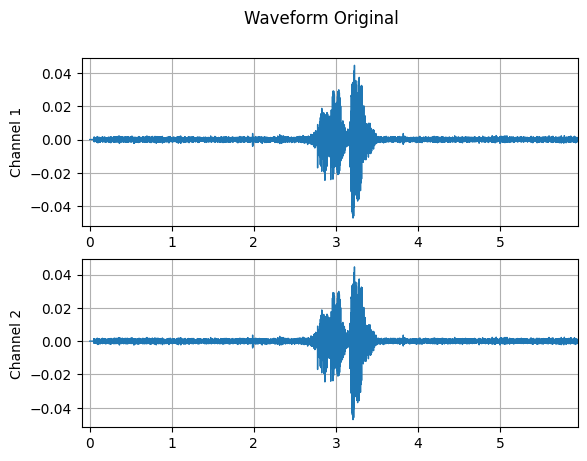

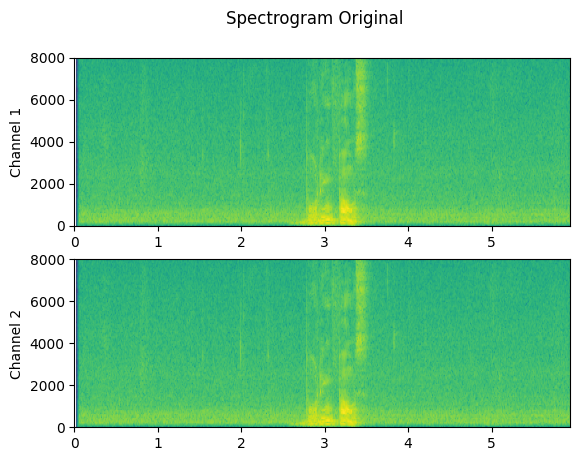

In [51]:
plot_waveform(waveform1.T, new_sample_rate, title="Waveform Original", xlim=(-0.1, waveform1.shape[0] / new_sample_rate))
plot_specgram(waveform1.T, new_sample_rate, title="Spectrogram Original", xlim=(0, waveform1.shape[0] / new_sample_rate))
Audio(waveform1.T, rate=new_sample_rate)

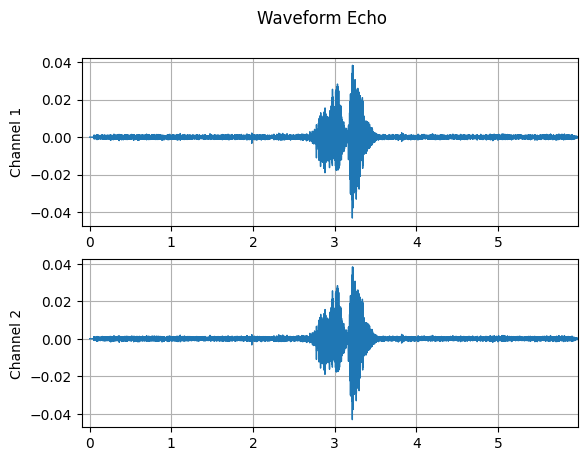

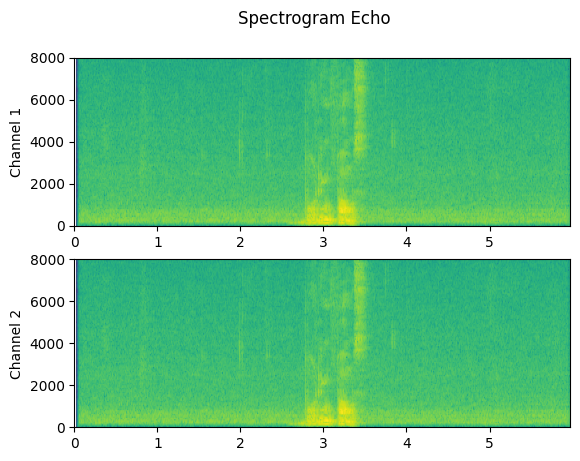

In [52]:
# With Echo
plot_waveform(waveform1_echo.T, new_sample_rate, title="Waveform Echo", xlim=(-0.1, waveform1_echo.shape[0] / new_sample_rate))
plot_specgram(waveform1_echo.T, new_sample_rate, title="Spectrogram Echo", xlim=(0, waveform1_echo.shape[0] / new_sample_rate))
Audio(waveform1_echo.T, rate=new_sample_rate)

### 1. 80% speech speed + Reverb

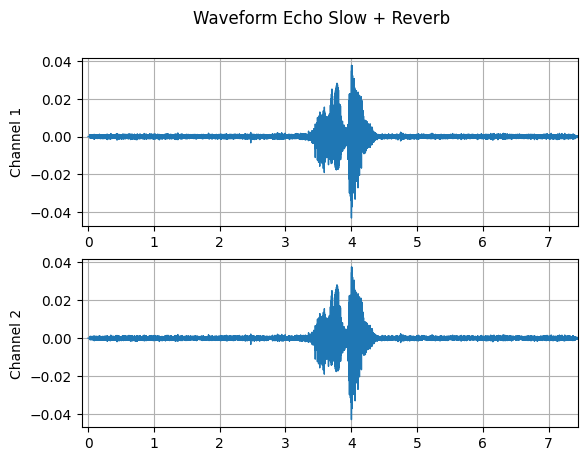

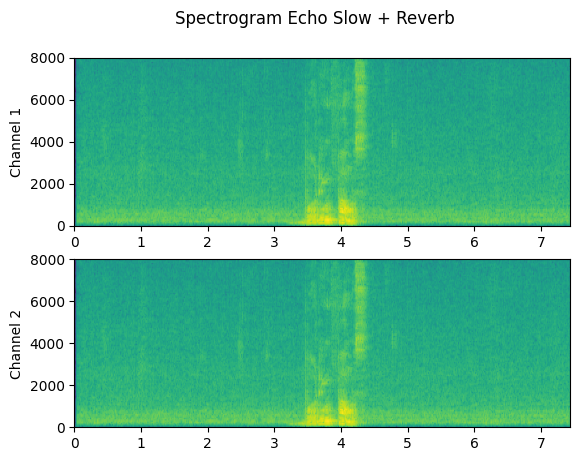

In [53]:
effects = ",".join(
    [
        "aecho=0.8:0.88:30:0.4", # Simulating a clinical reverb environment
        "atempo=0.8", # Simulating slow speech
    ],
)

waveform1_echo_slow = apply_effect(waveform1, new_sample_rate, effects)

# With Echo and Slow Speech
plot_waveform(waveform1_echo_slow.T, new_sample_rate, title="Waveform Echo Slow + Reverb", xlim=(-0.1, waveform1_echo_slow.shape[0] / new_sample_rate))
plot_specgram(waveform1_echo_slow.T, new_sample_rate, title="Spectrogram Echo Slow + Reverb", xlim=(0, waveform1_echo_slow.shape[0] / new_sample_rate))
Audio(waveform1_echo_slow.T, rate=new_sample_rate)

Since the Background Noise library does not work, we will have to manually merge two audio files together.

In [54]:
background_noise, bg_sr = torchaudio.load("hospital_noise.mp3", channels_first=False)
print(background_noise.shape)
print(bg_sr)

downsampler = Resample(bg_sr, new_sample_rate)
background_noise = downsampler(background_noise.T)
background_noise = background_noise.T
background_noise *= 0.35

background_noise.shape

torch.Size([1756800, 2])
44100


torch.Size([637388, 2])

In [55]:
min_length = min(waveform1.size(0), background_noise.size(0))
min_length

95109

In [56]:
waveform1 = waveform1[:min_length, :]
background_noise = background_noise[:min_length, :]

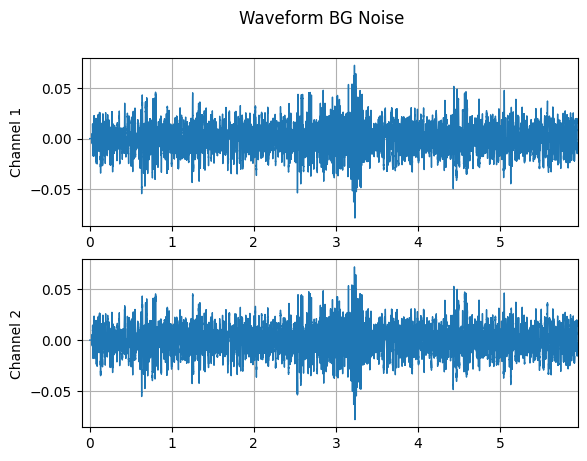

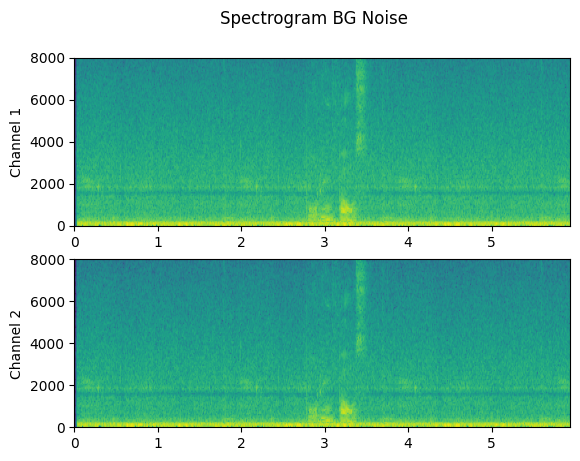

In [57]:
mixed_waveform = waveform1 + background_noise

plot_waveform(mixed_waveform.T, new_sample_rate, title="Waveform BG Noise", xlim=(-0.1, mixed_waveform.shape[0] / new_sample_rate))
plot_specgram(mixed_waveform.T, new_sample_rate, title="Spectrogram BG Noise", xlim=(0, mixed_waveform.shape[0] / new_sample_rate))

Audio(mixed_waveform.T, rate=new_sample_rate)

### 2. Reverb + Background Noise

In [58]:
effects = ",".join(
    [
        "aecho=0.8:0.88:30:0.4", # Simulating a clinical reverb environment
    ],
)

background_noise, bg_sr = torchaudio.load("hospital_noise.mp3", channels_first=False)
print(background_noise.shape)
print(bg_sr)

downsampler = Resample(bg_sr, new_sample_rate)
background_noise = downsampler(background_noise.T)
background_noise = background_noise.T
background_noise *= 0.35

background_noise.shape

torch.Size([1756800, 2])
44100


torch.Size([637388, 2])

In [59]:
waveform_1_echo = apply_effect(waveform1, new_sample_rate, effects)

In [60]:
min_length = min(waveform_1_echo.size(0), background_noise.size(0))
min_length

95589

In [61]:
waveform_1_echo = waveform_1_echo[:min_length, :]
background_noise = background_noise[:min_length, :]

In [62]:
waveform_1_echo.shape

torch.Size([95589, 2])

In [63]:
background_noise.shape

torch.Size([95589, 2])

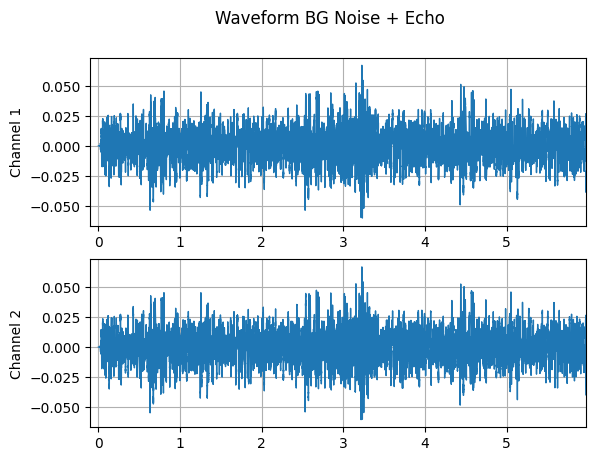

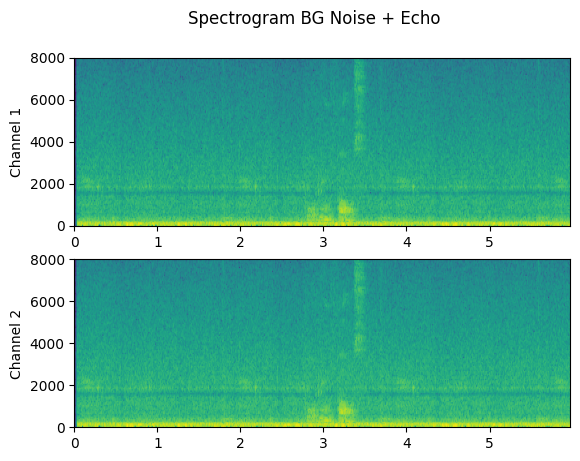

In [64]:
mixed_waveform = waveform_1_echo + background_noise

plot_waveform(mixed_waveform.T, new_sample_rate, title="Waveform BG Noise + Echo", xlim=(-0.1, mixed_waveform.shape[0] / new_sample_rate))
plot_specgram(mixed_waveform.T, new_sample_rate, title="Spectrogram BG Noise + Echo", xlim=(0, mixed_waveform.shape[0] / new_sample_rate))

Audio(mixed_waveform.T, rate=new_sample_rate)

### 3. 110% speech speed + Background Noise

In [70]:
effects = ",".join(
    [
        "atempo=1.2", # Simulating kan cheong speech
    ],
)

background_noise, bg_sr = torchaudio.load("hospital_noise.mp3", channels_first=False)
print(background_noise.shape)
print(bg_sr)

downsampler = Resample(bg_sr, new_sample_rate)
background_noise = downsampler(background_noise.T)
background_noise = background_noise.T
background_noise *= 0.35

background_noise.shape

torch.Size([1756800, 2])
44100


torch.Size([637388, 2])

In [71]:
waveform_1_fast = apply_effect(waveform1, new_sample_rate, effects)

In [72]:
min_length = min(waveform_1_fast.size(0), background_noise.size(0))
min_length

95109

In [73]:
waveform_1_fast = waveform_1_fast[:min_length, :]
background_noise = background_noise[:min_length, :]

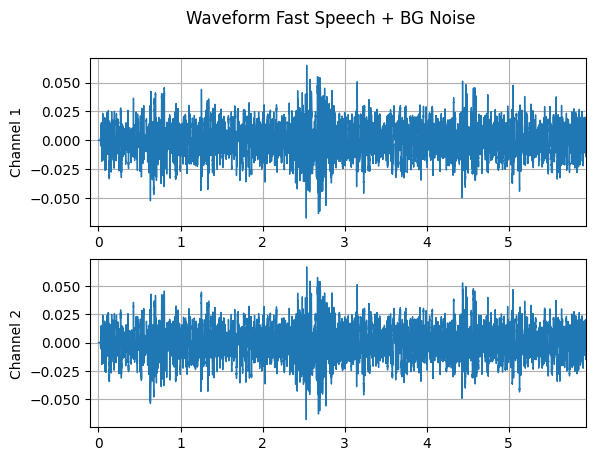

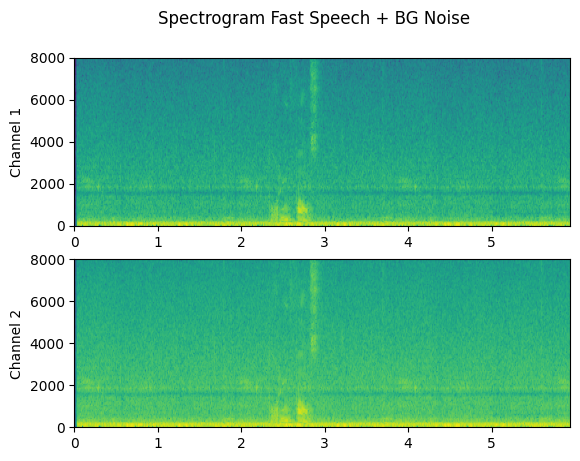

In [74]:
mixed_waveform = waveform_1_fast + background_noise

plot_waveform(mixed_waveform.T, new_sample_rate, title="Waveform Fast Speech + BG Noise", xlim=(-0.1, mixed_waveform.shape[0] / new_sample_rate))
plot_specgram(mixed_waveform.T, new_sample_rate, title="Spectrogram Fast Speech + BG Noise", xlim=(0, mixed_waveform.shape[0] / new_sample_rate))

Audio(mixed_waveform.T, rate=new_sample_rate)

### 4. Reverb + Slight Background Noise + 80% Speed

In [104]:
effects = ",".join(
    [
        "atempo=0.8", # Simulating slower speech
        "aecho=0.8:0.88:30:0.4", # Simulating a clinical reverb environment
    ],
)

background_noise, bg_sr = torchaudio.load("hospital_noise.mp3", channels_first=False)
print(background_noise.shape)
print(bg_sr)

downsampler = Resample(bg_sr, new_sample_rate)
background_noise = downsampler(background_noise.T)
background_noise = background_noise.T
background_noise *= 0.3

background_noise.shape

torch.Size([1756800, 2])
44100


torch.Size([637388, 2])

In [105]:
waveform_1_slow_reverb = apply_effect(waveform1, new_sample_rate, effects)

In [106]:
min_length = min(waveform_1_slow_reverb.size(0), background_noise.size(0))
min_length

118951

In [107]:
waveform_1_slow_reverb = waveform_1_slow_reverb[:min_length, :]
background_noise = background_noise[:min_length, :]

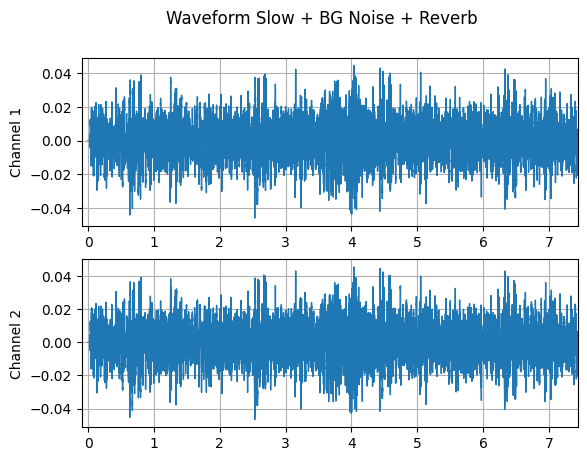

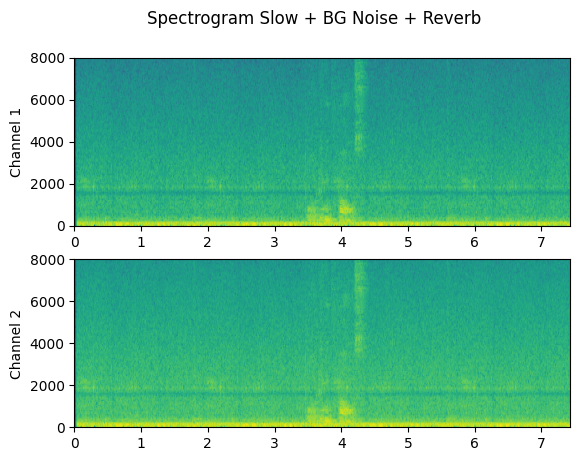

In [108]:
mixed_waveform = waveform_1_slow_reverb + background_noise

plot_waveform(mixed_waveform.T, new_sample_rate, title="Waveform Slow + BG Noise + Reverb", xlim=(-0.1, mixed_waveform.shape[0] / new_sample_rate))
plot_specgram(mixed_waveform.T, new_sample_rate, title="Spectrogram Slow + BG Noise + Reverb", xlim=(0, mixed_waveform.shape[0] / new_sample_rate))

Audio(mixed_waveform.T, rate=new_sample_rate)

In [109]:
torchaudio.save("test.wav", mixed_waveform.T, new_sample_rate)

### Applying to the whole training set

In [118]:
import torchaudio
from torchaudio.transforms import Resample
import pandas as pd
import os
from tqdm import tqdm

# Function to apply the effect
def apply_effect(waveform, sample_rate, effect):
    effector = torchaudio.io.AudioEffector(effect=effect)
    return effector.apply(waveform, sample_rate)

# Function to save the transformed audio
def save_audio(output_path, waveform, sample_rate):
    torchaudio.save(output_path, waveform.T, sample_rate)

# Create directory for processed audio files
output_dir = "samples/audio"
os.makedirs(output_dir, exist_ok=True)

# Iterate through the dataframe with tqdm to track progress
def process_audio_files(df):
    new_data = []
    
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Audio Files"):
        audio_path = row['audio_path']
        patient_id = row['patient']
        base_name = row['audio_base_name']
        
        # Load the original audio file
        waveform, original_sr = torchaudio.load(audio_path, channels_first=False)

        # Resample to desired sample rate
        downsampler = Resample(original_sr, new_sample_rate)
        waveform = downsampler(waveform.T)
        waveform = waveform.T

        # Define effect configurations
        effects = {
            'slow_speech_reverb': ",".join([
                "aecho=0.8:0.88:30:0.4",
                "atempo=0.8"
            ]),
            'reverb_bg_noise': ",".join([
                "aecho=0.8:0.88:30:0.4"
            ]),
            'fast_speech_bg_noise': ",".join([
                "atempo=1.2"
            ]),
            'slow_reverb_bg_noise': ",".join([
                "atempo=0.8",
                "aecho=0.8:0.88:30:0.4"
            ])
        }

        # Apply each effect
        for effect_name, effect in effects.items():
            # Apply the effect to the waveform
            transformed_waveform = apply_effect(waveform, new_sample_rate, effect)
            
            # Handle background noise if needed
            if 'bg_noise' in effect_name:
                background_noise, bg_sr = torchaudio.load("hospital_noise.mp3", channels_first=False)
                downsampler = Resample(bg_sr, new_sample_rate)
                background_noise = downsampler(background_noise.T).T
                background_noise *= 0.3  # Adjust the intensity of background noise
                
                # Mix background noise
                min_length = min(transformed_waveform.size(0), background_noise.size(0))
                transformed_waveform = transformed_waveform[:min_length, :]
                background_noise = background_noise[:min_length, :]
                transformed_waveform = transformed_waveform + background_noise

            # Save transformed audio
            output_file = os.path.join(output_dir, f"{patient_id}_{base_name}_{effect_name}.wav")
            save_audio(output_file, transformed_waveform, new_sample_rate)

            # Append the new row to new_data
            new_data.append({
                'Picture No.': row['Picture No.'],
                'Original': row['Original'],
                'Edited': row['Edited'],
                'patient': row['patient'],
                'audio_path': output_file,  # New audio file path
                'cleaned_transcript': row['cleaned_transcript'],
                'audio': transformed_waveform,
                'sampling_rate': new_sample_rate,
                'features': row['features'],
                'labels': row['labels'],
                'audio_base_name': os.path.basename(output_file),  # New base name
                'transcription': row['transcription']
            })
    
    # Create a new DataFrame with the augmented data
    new_df = pd.DataFrame(new_data)
    return new_df

# Set your desired sample rate
new_sample_rate = 16000

# Process the DataFrame
new_df = process_audio_files(df)

# Save or use the new DataFrame as needed
new_df.to_csv('train_set_with_augmented.csv', index=False)

Processing Audio Files: 100%|██████████| 1211/1211 [09:40<00:00,  2.09it/s]


In [119]:
new_df.head()

Picture No.       Original           Edited  patient  \
0        A-34  Boring pounds  boarding pounds  al_e092   
1        A-34  Boring pounds  boarding pounds  al_e092   
2        A-34  Boring pounds  boarding pounds  al_e092   
3        A-34  Boring pounds  boarding pounds  al_e092   
4        A-06           Call         card bed  al_e133   

                                          audio_path cleaned_transcript  \
0  samples/audio/al_e092_al_e092_A-34.m4a_slow_sp...      boring pounds   
1  samples/audio/al_e092_al_e092_A-34.m4a_reverb_...      boring pounds   
2  samples/audio/al_e092_al_e092_A-34.m4a_fast_sp...      boring pounds   
3  samples/audio/al_e092_al_e092_A-34.m4a_slow_re...      boring pounds   
4  samples/audio/al_e133_al_e133_A-06.m4a_slow_sp...           card bed   

                                               audio  sampling_rate  \
0  [[tensor(0.), tensor(0.)], [tensor(0.), tensor...          16000   
1  [[tensor(-2.3782e-13), tensor(-1.1156e-12)], [...          16000   
2  [[tensor(-2.3782e-13), tensor(-1.1156e-12)], [...          16000   
3  [[tensor(-2.3782e-13), tensor(-1.1156e-12)], [...          16000   
4  [[tensor(0.), tensor(0.)], [tensor(0.), tensor...          16000   

                                            features  \
0  [[-1.2991939 -1.2991939 -1.2991939 ... -1.2991...   
1  [[-1.2991939 -1.2991939 -1.2991939 ... -1.2991...   
2  [[-1.2991939 -1.2991939 -1.2991939 ... -1.2991...   
3  [[-1.2991939 -1.2991939 -1.2991939 ... -1.2991...   
4  [[-1.0863969 -1.0863969 -1.0863969 ... -1.0863...   

                                              labels  \
0  [50257, 50258, 50358, 50362, 2865, 278, 8059, ...   
1  [50257, 50258, 50358, 50362, 2865, 278, 8059, ...   
2  [50257, 50258, 50358, 50362, 2865, 278, 8059, ...   
3  [50257, 50258, 50358, 50362, 2865, 278, 8059, ...   
4    [50257, 50258, 50358, 50362, 9517, 3996, 50256]   

                                     audio_base_name       transcription  
0    al_e092_al_e092_A-34.m4a_slow_speech_reverb.wav            cancers   
1       al_e092_al_e092_A-34.m4a_reverb_bg_noise.wav            cancers   
2  al_e092_al_e092_A-34.m4a_fast_speech_bg_noise.wav            cancers   
3  al_e092_al_e092_A-34.m4a_slow_reverb_bg_noise.wav            cancers   
4    al_e133_al_e133_A-06.m4a_slow_speech_reverb.wav  no see you i m ok

In [120]:
combined_df = pd.concat([df, new_df])
combined_df.head()

Picture No.       Original  \
0        A-34  Boring pounds   
1        A-06           Call   
2      B-P-01   It's a woman   
3        A-26        Infront   
4        A-45        Library   

                                              Edited  patient  \
0                                    boarding pounds  al_e092   
1                                           card bed  al_e133   
2  It's a woman on the phone eh it‚Äôs a man eh o...  al_e101   
3                                             #NAME?  al_e101   
4                                            Library  al_e100   

                         audio_path  \
0    samples/audio/al_e092_A-34.m4a   
1    samples/audio/al_e133_A-06.m4a   
2  samples/audio/al_e101_B-P-01.m4a   
3    samples/audio/al_e101_A-26.m4a   
4    samples/audio/al_e100_A-45.m4a   

                                  cleaned_transcript  \
0                                      boring pounds   
1                                           card bed   
2  it s a woman on the phone eh it s a man eh oh ...   
3                                           elephant   
4                                            library   

                                               audio  sampling_rate  \
0  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...          16000   
1  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...          16000   
2  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...          16000   
3  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...          16000   
4  [ 0.000000e+00  0.000000e+00  0.000000e+00 ......          16000   

                                            features  \
0  [[-1.2991939 -1.2991939 -1.2991939 ... -1.2991...   
1  [[-1.0863969 -1.0863969 -1.0863969 ... -1.0863...   
2  [[-0.9689208  -0.9689208  -0.9689208  ... -0.2...   
3  [[-1.2470286 -1.2470286 -1.2470286 ... -1.2470...   
4  [[-0.99934685 -0.99934685 -0.99934685 ... -0.9...   

                                              labels     audio_base_name  \
0  [50257, 50258, 50358, 50362, 2865, 278, 8059, ...    al_e092_A-34.m4a   
1    [50257, 50258, 50358, 50362, 9517, 3996, 50256]    al_e133_A-06.m4a   
2  [50257, 50258, 50358, 50362, 270, 264, 257, 24...  al_e101_B-P-01.m4a   
3  [50257, 50258, 50358, 50362, 11129, 33959, 50256]    al_e101_A-26.m4a   
4         [50257, 50258, 50358, 50362, 32016, 50256]    al_e100_A-45.m4a   

                                       transcription  
0                                           cancers   
1                                 no see you i m ok   
2  it s a woman on the phone it s a man it s a ma...  
3                                      and fun yeah   
4                                           library

In [122]:
combined_df.sort_values(by=['audio_base_name'])

Picture No.      Original  \
506         A-01       Already   
982         A-03            Is   
335         A-04        Eating   
252         A-08      Drinking   
774         A-11      Is Kitty   
...          ...           ...   
2856        A-68         Tired   
3094      A-P-01  What is this   
3093      A-P-01  What is this   
3095      A-P-01  What is this   
3092      A-P-01  What is this   

                                                 Edited  patient  \
506   Orh this one look like my bock my cre crack bo...  al_e026   
982   Body is a frok fruk frukow kang kuck of uh cal...  al_e026   
335   Uh cra -cough- look like a b -clear throat- ba...  al_e026   
252   The krang uh krang kricking uh body kitting uh...  al_e026   
774   The brog the brog is a bro brock brordy is kit...  al_e026   
...                                                 ...      ...   
2856                                             #NAME?  al_e137   
3094        What is this uh I think it is a Soccer ball  al_e137   
3093        What is this uh I think it is a Soccer ball  al_e137   
3095        What is this uh I think it is a Soccer ball  al_e137   
3092        What is this uh I think it is a Soccer ball  al_e137   

                                             audio_path  \
506                      samples/audio/al_e026_A-01.m4a   
982                      samples/audio/al_e026_A-03.m4a   
335                      samples/audio/al_e026_A-04.m4a   
252                      samples/audio/al_e026_A-08.m4a   
774                      samples/audio/al_e026_A-11.m4a   
...                                                 ...   
2856  samples/audio/al_e137_al_e137_A-68.m4a_slow_sp...   
3094  samples/audio/al_e137_al_e137_A-P-01.m4a_fast_...   
3093  samples/audio/al_e137_al_e137_A-P-01.m4a_rever...   
3095  samples/audio/al_e137_al_e137_A-P-01.m4a_slow_...   
3092  samples/audio/al_e137_al_e137_A-P-01.m4a_slow_...   

                                     cleaned_transcript  \
506   orh this one look like my bock my cre crack bo...   
982   body is a frok fruk frukow kang kuck of uh cal...   
335   uh cra cough look like a b clear throat bag of...   
252   the krang uh krang kricking uh body kitting uh...   
774   the brog the brog is a bro brock brordy is kit...   
...                                                 ...   
2856                                               tyre   
3094        what is this uh i think it is a soccer ball   
3093        what is this uh i think it is a soccer ball   
3095        what is this uh i think it is a soccer ball   
3092        what is this uh i think it is a soccer ball   

                                                  audio  sampling_rate  \
506   [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...          16000   
982   [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...          16000   
335   [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...          16000   
252   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ......          16000   
774   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ......          16000   
...                                                 ...            ...   
2856  [[tensor(0.), tensor(0.)], [tensor(0.), tensor...          16000   
3094  [[tensor(-2.3782e-13), tensor(-1.1156e-12)], [...          16000   
3093  [[tensor(-2.3782e-13), tensor(-1.1156e-12)], [...          16000   
3095  [[tensor(-2.3782e-13), tensor(-1.1156e-12)], [...          16000   
3092  [[tensor(0.), tensor(0.)], [tensor(0.), tensor...          16000   

                                               features  \
506   [[-1.199933   -1.199933   -1.199933   ... -0.5...   
982   [[-1.2169983 -1.2169983 -1.2169983 ... -1.2169...   
335   [[-0.7394706 -0.7394706 -0.7394706 ... -0.7394...   
252   [[-1.2303371 -1.2303371 -1.2303371 ... -1.2303...   
774   [[-1.1389182  -1.1389182  -1.1389182  ... -0.1...   
...                                                 ...   
2856  [[-1.2603352 -1.2603352 -1.2603352 ... -1.2603...   


In [126]:
combined_df.to_csv("train_set.csv", index=False)

### Upload the blobs

In [124]:
blob = bucket.blob("audio/")

# Get the files from the directory
audio_path = "samples/audio"

for file in tqdm(os.listdir(audio_path), desc="Uploading to bucket"):
    blob = bucket.blob(f"audio/{file}")
    blob.upload_from_filename(f"{audio_path}/{file}")

Uploading to bucket: 100%|██████████| 6055/6055 [33:12<00:00,  3.04it/s]


In [127]:
blob = bucket.blob("fine_tune_transcripts/train_set.csv")
blob.upload_from_filename("train_set.csv")